# Imports

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install opencv-python-headless
# %pip install scikit-image
# %pip install basic-image-eda
# %pip install seaborn
# %pip install torchvision
# %pip install sklearn

In [2]:
import os
import glob
import time
import copy

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mp_image
import seaborn as sns

from IPython.display import Image, display

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

import torch
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch.nn as nn

from sklearn.metrics import confusion_matrix

# Data Load

In [3]:
# credits: https://github.com/yuliyabohdan/Skin-diseases-classification-Dermnet-/blob/main/skin_diseases_clas_ResNet50.ipynb

DIR = 'Data/dermnet'
DIR_TRAIN = f'{DIR}/train/'
DIR_TEST = f'{DIR}/test/'

classes = os.listdir(DIR_TRAIN)
print(f'Total classes: {len(classes)}')

# total train and test images
train_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    class_dict.update({'Class': _class, 
                       'Train': len(os.listdir(DIR_TRAIN + _class)), 
                       'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print(f'Total num train images: {train_count}')
print(f'Total num test images: {test_count}')
print(pd.DataFrame(classes_df))

Total classes: 23
Total num train images: 15557
Total num test images: 4003
                                                Class  Train  Test
0                    Herpes HPV and other STDs Photos    405   102
1          Lupus and other Connective Tissue diseases    420   105
2                 Melanoma Skin Cancer Nevi and Moles    463   116
3                                     Urticaria Hives    212    53
4                                     Vascular Tumors    482   121
5                                    Systemic Disease    606   152
6                  Nail Fungus and other Nail Disease   1040   261
7   Psoriasis pictures Lichen Planus and related d...   1405   352
8   Cellulitis Impetigo and other Bacterial Infect...    288    73
9   Tinea Ringworm Candidiasis and other Fungal In...   1300   325
10  Scabies Lyme Disease and other Infestations an...    431   108
11  Hair Loss Photos Alopecia and other Hair Diseases    239    60
12         Warts Molluscum and other Viral Infections

In [4]:
# map class labels to integer index

train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(f'{DIR_TRAIN}{_class}/{img}')
    
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(f'{DIR_TEST}{_class}/{img}')

classToInt = {classes[i]: i for i in range(len(classes))}
intToClass = dict(map(reversed, classToInt.items()))

for k, v in classToInt.items():
    print(k)

Herpes HPV and other STDs Photos
Lupus and other Connective Tissue diseases
Melanoma Skin Cancer Nevi and Moles
Urticaria Hives
Vascular Tumors
Systemic Disease
Nail Fungus and other Nail Disease
Psoriasis pictures Lichen Planus and related diseases
Cellulitis Impetigo and other Bacterial Infections
Tinea Ringworm Candidiasis and other Fungal Infections
Scabies Lyme Disease and other Infestations and Bites
Hair Loss Photos Alopecia and other Hair Diseases
Warts Molluscum and other Viral Infections
Eczema Photos
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Vasculitis Photos
Poison Ivy Photos and other Contact Dermatitis
Exanthems and Drug Eruptions
Atopic Dermatitis Photos
Light Diseases and Disorders of Pigmentation
Acne and Rosacea Photos
Seborrheic Keratoses and other Benign Tumors
Bullous Disease Photos


# Data Split/Transforms

In [5]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
    transforms.RandomRotation([-8, +8]),                                           # if augmentation
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      # if augmentation
    transforms.RandomHorizontalFlip(),                                            # if augmentation
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.541, 0.414, 0.382], std=[0.256, 0.215, 0.209])
]))
test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.541, 0.414, 0.382], std=[0.256, 0.215, 0.209])
]))

In [6]:
test_size = int(0.5 * len(test_dataset))
valid_size = len(test_dataset) - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, 
                                                            [valid_size, test_size])

# Train/Val Data Loader

In [7]:
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=24)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=24, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=24, drop_last=False)

# Modeling

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:               
                model.eval()   # Set model to evaluate mode
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                      # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

               # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [9]:
def test_model(model, dl, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    total = 0
    num_correct = 0
    with torch.no_grad():
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            num_correct += (predicted == labels).sum()
        print(f'Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}')    
        true_labels = np.hstack(true_labels)
        predictions = np.hstack(predictions)

    return true_labels, predictions

In [10]:
# x, y - find the img from class x labelled as class y 
def test(model, dl, x, y, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    images_list = []

    with torch.no_grad():
        for images, labels in dl:
            images_list.append(images.cpu().numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    
    for n in range(60):
        for i in range(32):
            if (true_labels[n][i] == x)  & (predictions[n][i] == y):
                #inv_tensor = inv_normalize(image_list[n][i]])
                plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
                plt.show()

In [11]:
# Number of epochs to train for
num_epochs = 5 #100

model = models.resnet50(weights='DEFAULT')
model.fc = nn.Linear(2048, 23, bias=True)

# Detect if we have a GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

cuda:0


In [12]:
# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 2.4214 Acc: 0.2946
val Loss: 2.0193 Acc: 0.4139

Epoch 1/4
----------
train Loss: 1.7776 Acc: 0.4738
val Loss: 1.6982 Acc: 0.5042

Epoch 2/4
----------
train Loss: 1.3766 Acc: 0.5894
val Loss: 1.5265 Acc: 0.5417

Epoch 3/4
----------
train Loss: 1.0406 Acc: 0.6863
val Loss: 1.4285 Acc: 0.5816

Epoch 4/4
----------
train Loss: 0.7793 Acc: 0.7635
val Loss: 1.3960 Acc: 0.6051

Training complete in 25m 59s
Best val Acc: 0.605092


In [13]:
torch.save(model, 'model/dermnet_resnet50.pt')

In [14]:
model = torch.load('model/dermnet_resnet50.pt')

Test Accuracy of the model: 59.54


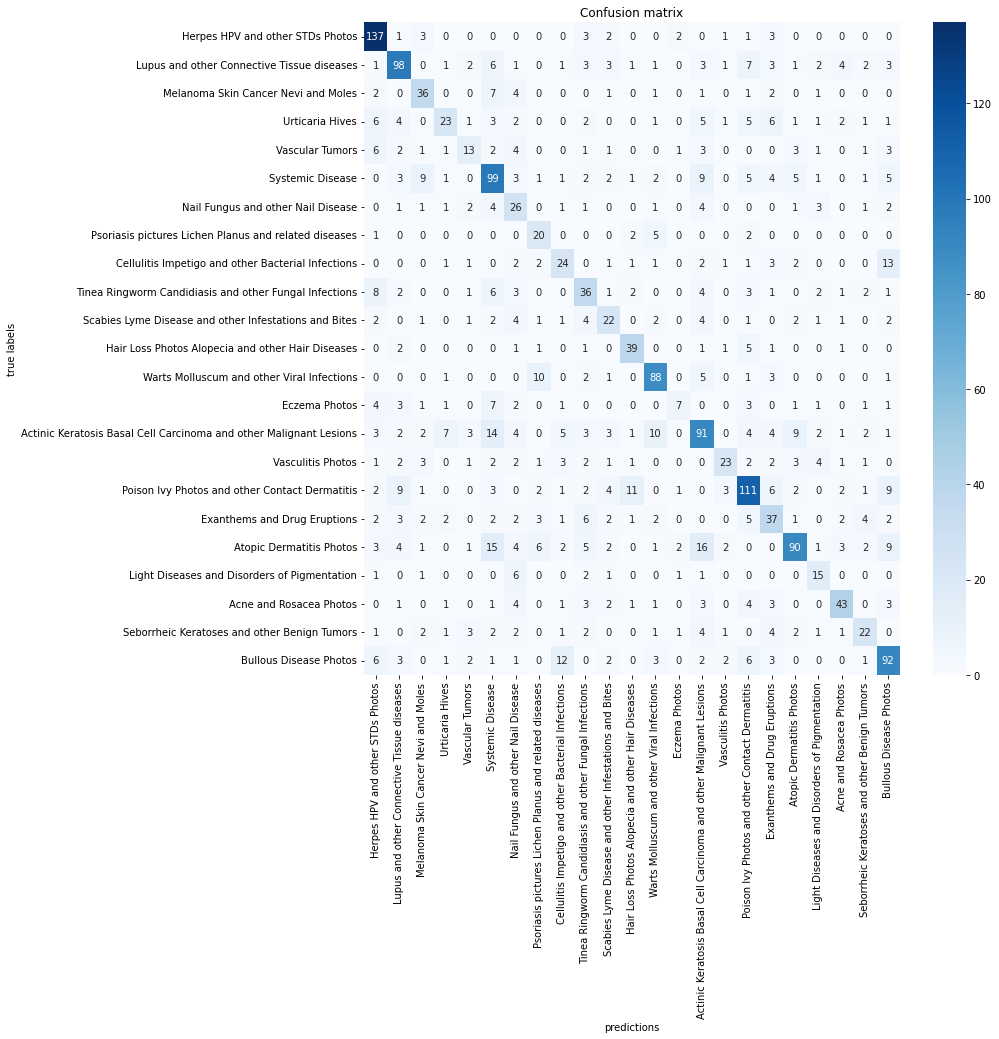

In [15]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [16]:
# # False prediction
# test(model, dataloader_test, 5, 16) # (eczema, scabies lyme)

In [17]:
# # Correct prediction of 'Eczema Photos'
# test(model, dataloader_test, 5, 5)

In [18]:
# Trace model

# must be the same size a minibatch with 1 example image
example = torch.rand(1, 3, 224, 224)

# move model back to cpu, do tracing, and optimize
model_conv = model.to('cpu')
traced_script_module = torch.jit.trace(model_conv, example)
torchscript_model_optimized = optimize_for_mobile(traced_script_module)

# save optimized model for mobile
PATH = 'model/dermnet_resnet50_traced.pt'
torchscript_model_optimized.save(PATH)